## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [65]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from pprint import pprint

from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist

In [2]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [4]:
# Opening JSON file 
f = open('/kaggle/input/automatic-ticket-classification/complaints-2021-05-14_08_16.json')# Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [5]:
# Inspect the dataframe to understand the given data.
df.sample(10)


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
27762,complaint-public-v2,complaint,2349443,0.0,None,70809,2349443,"Loan servicing, payments, escrow account",2017-02-17T12:00:00-05:00,LA,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2017-02-23T12:00:00-05:00,None,Conventional adjustable mortgage (ARM),Yes,,None,N/A
23177,complaint-public-v2,complaint,536045,0.0,None,660XX,536045,"Loan modification,collection,foreclosure",2013-09-20T12:00:00-05:00,KS,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2013-09-20T12:00:00-05:00,None,Other mortgage,Yes,,None,N/A
32029,complaint-public-v2,complaint,2656039,0.0,Older American,10024,2656039,Managing an account,2017-08-31T12:00:00-05:00,NY,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2017-08-31T12:00:00-05:00,None,Checking account,Yes,,Deposits and withdrawals,Consent not provided
57772,complaint-public-v2,complaint,3094576,0.0,None,78723,3094576,Problem with a purchase shown on your statement,2018-12-07T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2018-12-07T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I previously submitted a dispute regarding the...,Overcharged for something you did purchase wit...,Consent provided
5861,complaint-public-v2,complaint,3659926,0.0,None,840XX,3659926,Problem with a purchase shown on your statement,2020-05-20T12:00:00-05:00,UT,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2020-05-20T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I found out that my card was stolen when revie...,Card was charged for something you did not pur...,Consent provided
21505,complaint-public-v2,complaint,3601775,0.0,None,29456,3601775,Opening an account,2020-04-10T12:00:00-05:00,SC,...,Closed with explanation,JPMORGAN CHASE & CO.,Phone,2020-04-10T12:00:00-05:00,None,Checking account,Yes,,Account opened as a result of fraud,N/A
73296,complaint-public-v2,complaint,3143936,0.0,None,799XX,3143936,Money was not available when promised,2019-02-06T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-02-06T12:00:00-05:00,None,Domestic (US) money transfer,Yes,US Dollar Wire transfer held due to OFAC COMPL...,None,Consent provided
1004,complaint-public-v2,complaint,3265828,0.0,None,89183,3265828,Managing an account,2019-06-04T12:00:00-05:00,NV,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-06T12:00:00-05:00,None,Checking account,Yes,,Deposits and withdrawals,N/A
60711,complaint-public-v2,complaint,196690,0.0,None,10003,196690,Rewards,2012-11-25T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2012-11-29T12:00:00-05:00,None,None,Yes,,None,N/A
50057,complaint-public-v2,complaint,259630,0.0,None,48382,259630,"Loan modification,collection,foreclosure",2013-01-28T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Fax,2013-01-30T12:00:00-05:00,None,Other mortgage,Yes,,None,N/A


In [6]:
df.shape

(78313, 22)

In [7]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [8]:
#Assign new column names
for column in df.columns:
    new_column = column.replace("_","").replace("source.", "")
    df.rename(columns={column: new_column}, inplace=True)

In [9]:
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zipcode', 'complaintid',
       'issue', 'datereceived', 'state', 'consumerdisputed', 'product',
       'companyresponse', 'company', 'submittedvia', 'datesenttocompany',
       'companypublicresponse', 'subproduct', 'timely',
       'complaintwhathappened', 'subissue', 'consumerconsentprovided'],
      dtype='object')

In [10]:
df.sample(10)

,index,type,id,score,tags,zipcode,complaintid,issue,datereceived,state,...,companyresponse,company,submittedvia,datesenttocompany,companypublicresponse,subproduct,timely,complaintwhathappened,subissue,consumerconsentprovided
43871,complaint-public-v2,complaint,3111626,0.0,None,98272,3111626,Managing an account,2018-12-27T12:00:00-05:00,WA,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2018-12-28T12:00:00-05:00,None,Checking account,Yes,,Deposits and withdrawals,N/A
44189,complaint-public-v2,complaint,3089943,0.0,None,89002,3089943,Managing an account,2018-12-03T12:00:00-05:00,NV,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2018-12-11T12:00:00-05:00,None,Checking account,Yes,,Deposits and withdrawals,Consent not provided
5010,complaint-public-v2,complaint,3425795,0.0,Servicemember,92056,3425795,Problem with a purchase shown on your statement,2019-11-02T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-11-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Credit card company isn't resolving a dispute ...,Consent not provided
5418,complaint-public-v2,complaint,3936443,0.0,None,32904,3936443,Incorrect information on your report,2020-11-04T12:00:00-05:00,FL,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2020-11-04T12:00:00-05:00,None,Loan,Yes,,Account status incorrect,Consent not provided
22394,complaint-public-v2,complaint,3216196,0.0,None,077XX,3216196,Struggling to pay mortgage,2019-04-18T12:00:00-05:00,NJ,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-18T12:00:00-05:00,None,Conventional home mortgage,Yes,I received a call from XXXX XXXX Bank ( subseq...,None,Consent provided
49692,complaint-public-v2,complaint,443082,0.0,None,02886,443082,"Loan modification,collection,foreclosure",2013-06-26T12:00:00-05:00,RI,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2013-06-28T12:00:00-05:00,None,Other mortgage,Yes,,None,N/A
33302,complaint-public-v2,complaint,3652053,0.0,Older American,630XX,3652053,"Other features, terms, or problems",2020-05-14T12:00:00-05:00,MO,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2020-05-14T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,My Southwest Rewards credit card by Chase Bank...,Problem with customer service,Consent provided
72589,complaint-public-v2,complaint,544315,0.0,None,941XX,544315,"Application, originator, mortgage broker",2013-09-26T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2013-09-27T12:00:00-05:00,None,Conventional fixed mortgage,Yes,,None,N/A
13427,complaint-public-v2,complaint,68532,0.0,None,98033,68532,"Loan modification,collection,foreclosure",2012-05-01T12:00:00-05:00,WA,...,Closed with non-monetary relief,JPMORGAN CHASE & CO.,Web,2012-05-02T12:00:00-05:00,None,Conventional fixed mortgage,Yes,,None,N/A
44823,complaint-public-v2,complaint,1145738,0.0,Servicemember,04981,1145738,"Loan modification,collection,foreclosure",2014-12-06T12:00:00-05:00,ME,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2014-12-06T12:00:00-05:00,None,VA mortgage,Yes,,None,N/A


In [11]:
(df.complaintwhathappened == "").sum()

57241

In [12]:
#Assign nan in place of blanks in the complaints column
df[df.complaintwhathappened == ""] = np.nan 

In [13]:
(df.complaintwhathappened == "").sum()

0

In [14]:
(df.complaintwhathappened == np.nan).sum()

0

In [15]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaintwhathappened'], inplace=True)

In [16]:
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [17]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
    # Make the text lowercase
    text = text.lower()
    
    # Remove text in square brackets using regular expression
    text = re.sub(r'\[.*?\]', '', text)
    
    # Remove punctuation using string library
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove words containing numbers using regular expression
    text = re.sub(r'\w*\d\w*', '', text)
    
    return text

In [18]:
#Write your function to Lemmatize the texts
def lemmatize_text(text):
    # Tokenize the text into words
    words = word_tokenize(text.lower())
    
    # Initialize the WordNet Lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # Lemmatize each word using its part of speech (POS)
    lemmatized_words = []
    for word, pos in nltk.pos_tag(words):
        pos_letter = pos[0].lower() if pos[0].lower() in ['a', 'r', 'n', 'v'] else 'n'
        lemma = lemmatizer.lemmatize(word, pos=pos_letter)
        lemmatized_words.append(lemma)
    
    # Join the lemmatized words back into a sentence
    lemmatized_text = ' '.join(lemmatized_words)
    
    return lemmatized_text

In [19]:
df['cleaned_complaints'] = df['complaintwhathappened'].apply(clean_text)

In [20]:
from tqdm import tqdm
tqdm.pandas()
df['lemmatized_complaints'] = df['cleaned_complaints'].progress_apply(lemmatize_text)

100%|██████████| 21072/21072 [05:00<00:00, 70.04it/s] 


In [21]:
df['lemmatized_complaints'].sample(10)

17771    on thursday xxxx xxxx xxxx i deposit a check o...
25973    i be attack by a xxxx in the parking lot durin...
10980    i have have credit card with chase bank for th...
61401    when recently sign paperwork to open a checkin...
57468    i have have checkingsavings account at j p mor...
62332    dear cfpb thank you very for help me regard my...
61169    our mortgage payment be month late a xxxx u be...
30088    i have be in conflict with jp morgan chase ban...
10223    there be a large ach debit hit my chase check ...
57131    my daughter open a fraudulent credit card acco...
Name: lemmatized_complaints, dtype: object

In [22]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = pd.DataFrame(columns=['complaintwhathappened','lemmatized_complaints'], data=df[['complaintwhathappened','lemmatized_complaints']])

In [23]:
df_clean

,complaintwhathappened,lemmatized_complaints
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and i apprec...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgrade my xxxx xxxx card in and be tell by ...
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent app...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket i come...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...
...,...,...
78303,After being a Chase Card customer for well ove...,after be a chase card customer for well over a...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx i call chas my xxxx xxxx...
78310,I am not familiar with XXXX pay and did not un...,i be not familiar with xxxx pay and do not und...
78311,I have had flawless credit for 30 yrs. I've ha...,i have have flawless credit for yr ive have ch...


In [24]:
# Write your function to extract the POS tags
def extract_pos_tag(sentence):
    # Tokenize the sentence into words
    words = word_tokenize(sentence)
    
    # Perform POS tagging using nltk.pos_tag
    pos_tags = nltk.pos_tag(words)
    
    # Extract words with tags 'NN', join them, and return
    return ' '.join([word for (word, tag) in pos_tags if tag == "NN" and word != 'i'])

df_clean["complaint_POS_removed"] = df_clean["lemmatized_complaints"].progress_apply(extract_pos_tag)
df_clean["length"] = df_clean["complaint_POS_removed"].progress_apply(len)


100%|██████████| 21072/21072 [00:00<00:00, 584199.50it/s]


In [25]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaintwhathappened,lemmatized_complaints,complaint_POS_removed,length
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and i apprec...,morning name stop bank cardmember service ask ...,153
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgrade my xxxx xxxx card in and be tell by ...,card agent upgrade date agent information orde...,105
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent app...,card report application identity consent servi...,74
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket i come...,try book xxxx ticket offer ticket card informa...,423
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son deposit chase account fund bank account mo...,165
...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,216
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx i call chas my xxxx xxxx...,call chas visa credit card provider claim purc...,665
78310,I am not familiar with XXXX pay and did not un...,i be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,723
78311,I have had flawless credit for 30 yrs. I've ha...,i have have flawless credit for yr ive have ch...,credit credit card chase freedom xxxx problem ...,485


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




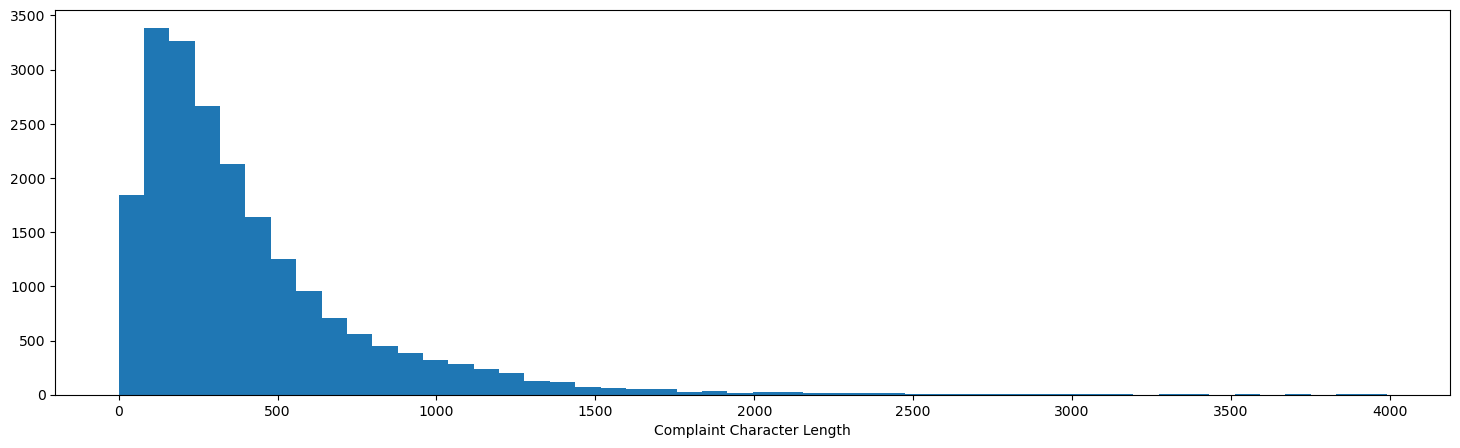

In [26]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=(18,5))
plt.hist([l for l in df_clean.length if l < 4000], bins=50)
plt.xlabel("Complaint Character Length")
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

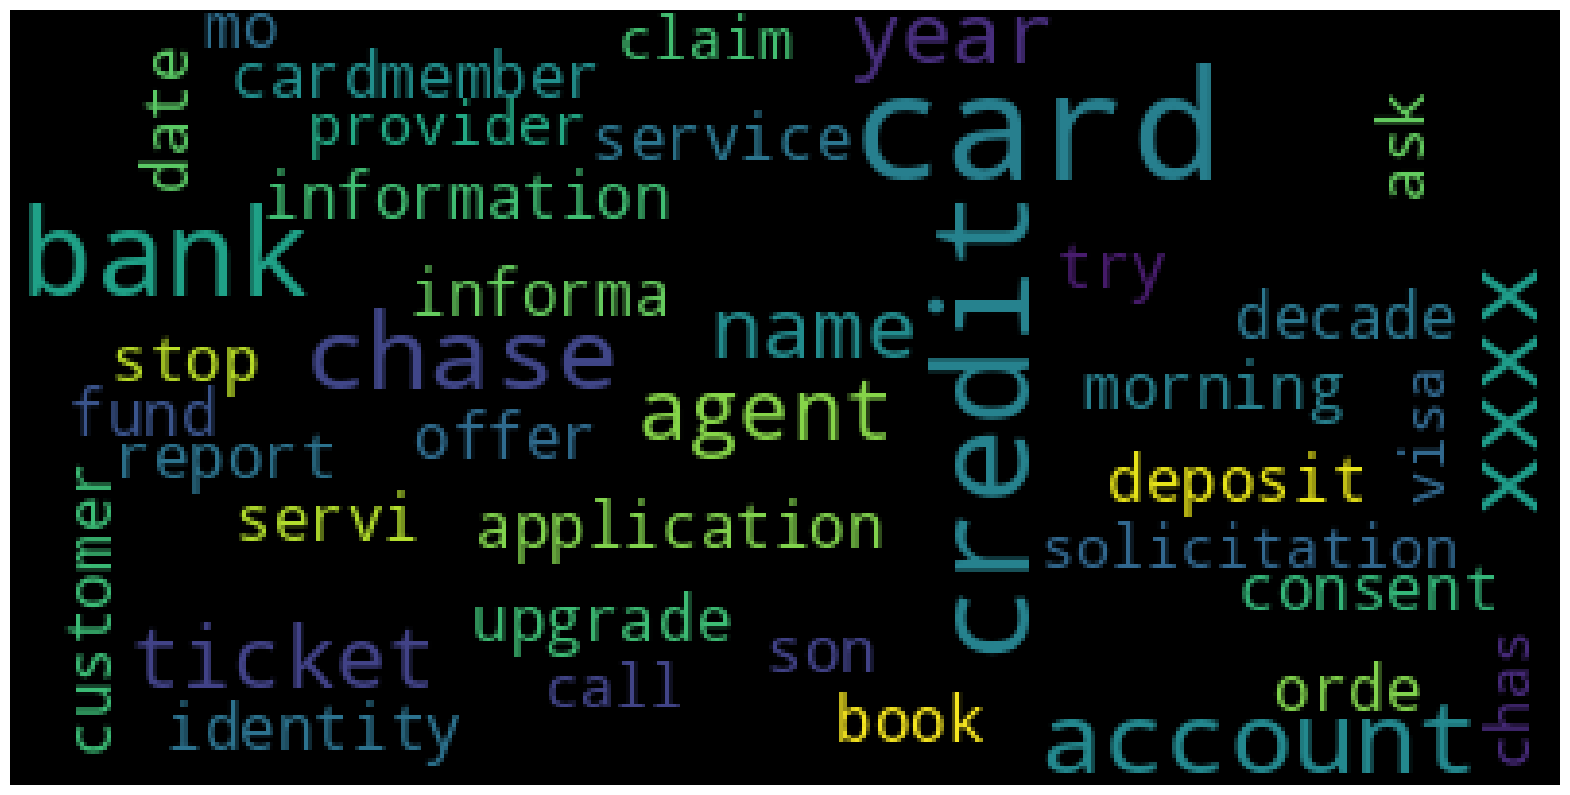

In [27]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud

wordcloud = WordCloud(
    max_words=40,
    max_font_size=40
).generate(str(df_clean['complaint_POS_removed']))

fig = plt.figure(figsize=(20,15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [28]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [29]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
complaints_list = df_clean['Complaint_clean'].tolist()

# Concatenate all complaints into a single string
all_complaints_text = " ".join(complaints_list)

# Tokenize the text into words
words = word_tokenize(all_complaints_text)

# Calculate the frequency distribution of unigrams
fdist = FreqDist(words)

# Get the top 30 most common unigrams
top_30_unigrams = fdist.most_common(30)

# Create a DataFrame to display the results
top_30_unigrams_df = pd.DataFrame(top_30_unigrams, columns=['Unigram', 'Frequency'])

# Display the top 30 unigrams
print(top_30_unigrams_df)

        Unigram  Frequency
0         chase      49788
1       account      47422
2          xxxx      37844
3        credit      34132
4          card      29299
5          bank      28504
6       payment      21168
7          time      16046
8        charge      14800
9           day      12972
10        check      12856
11     xxxxxxxx      12437
12        money      11961
13         call      11134
14         loan      11002
15        state       9936
16       letter       9669
17  information       9653
18       report       9040
19          fee       8653
20  transaction       8650
21       number       8616
22        month       8463
23       amount       8393
24         year       8292
25     mortgage       8189
26     customer       8163
27      service       7840
28        claim       7822
29      balance       7760


In [30]:
#Print the top 10 words in the unigram frequency
top_30_unigrams_df.head(10)

,Unigram,Frequency
0,chase,49788
1,account,47422
2,xxxx,37844
3,credit,34132
4,card,29299
5,bank,28504
6,payment,21168
7,time,16046
8,charge,14800
9,day,12972


In [31]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
# Create bigrams from the list of words
bigrams = list(nltk.bigrams(words))

# Calculate the frequency distribution of bigrams
fdist = FreqDist(bigrams)

# Get the top 30 most common bigrams
top_30_bigrams = fdist.most_common(30)

# Create a DataFrame to display the results
top_30_bigrams_df = pd.DataFrame(top_30_bigrams, columns=['Bigram', 'Frequency'])

# Display the top 30 bigrams
print(top_30_bigrams_df)

                 Bigram  Frequency
0        (credit, card)      12769
1          (xxxx, xxxx)       4008
2      (credit, report)       3967
3         (chase, bank)       3327
4   (customer, service)       3082
5       (chase, credit)       3082
6      (check, account)       2696
7       (bank, account)       2671
8      (account, chase)       2660
9      (chase, account)       2345
10   (account, account)       2074
11        (phone, call)       1647
12      (account, bank)       1625
13        (debit, card)       1563
14      (credit, score)       1536
15      (card, account)       1533
16  (checking, account)       1527
17        (xxxx, chase)       1491
18        (call, chase)       1485
19    (account, credit)       1413
20        (card, chase)       1327
21     (interest, rate)       1291
22     (credit, bureau)       1283
23     (money, account)       1271
24      (business, day)       1262
25      (phone, number)       1242
26      (account, xxxx)       1236
27   (payment, payme

In [32]:
#Print the top 10 words in the bigram frequency
top_30_bigrams_df.head(10)

,Bigram,Frequency
0,"(credit, card)",12769
1,"(xxxx, xxxx)",4008
2,"(credit, report)",3967
3,"(chase, bank)",3327
4,"(customer, service)",3082
5,"(chase, credit)",3082
6,"(check, account)",2696
7,"(bank, account)",2671
8,"(account, chase)",2660
9,"(chase, account)",2345


In [33]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
# Create trigrams from the list of words
trigrams = list(nltk.ngrams(words, 3))

# Calculate the frequency distribution of trigrams
fdist = FreqDist(trigrams)

# Get the top 30 most common trigrams
top_30_trigrams = fdist.most_common(30)

# Create a DataFrame to display the results
top_30_trigrams_df = pd.DataFrame(top_30_trigrams, columns=['Trigram', 'Frequency'])

# Display the top 30 trigrams
print(top_30_trigrams_df)

                           Trigram  Frequency
0            (chase, credit, card)       2135
1          (credit, card, account)       1000
2          (credit, card, company)        980
3            (credit, card, chase)        634
4        (inquiry, credit, report)        477
5           (credit, card, credit)        475
6               (xxxx, xxxx, xxxx)        434
7           (charge, credit, card)        404
8          (account, credit, card)        393
9      (credit, reporting, agency)        385
10      (chase, customer, service)        369
11            (xxxx, credit, card)        361
12            (card, credit, card)        359
13            (bank, credit, card)        358
14            (credit, card, bank)        347
15        (credit, report, credit)        330
16        (credit, reporting, act)        329
17         (credit, card, payment)        277
18          (credit, card, charge)        276
19       (account, credit, report)        271
20         (chase, check, account)

In [34]:
#Print the top 10 words in the trigram frequency
top_30_trigrams_df.head(10)

,Trigram,Frequency
0,"(chase, credit, card)",2135
1,"(credit, card, account)",1000
2,"(credit, card, company)",980
3,"(credit, card, chase)",634
4,"(inquiry, credit, report)",477
5,"(credit, card, credit)",475
6,"(xxxx, xxxx, xxxx)",434
7,"(charge, credit, card)",404
8,"(account, credit, card)",393
9,"(credit, reporting, agency)",385


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [35]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [36]:
#All masked texts has been removed
df_clean

,complaintwhathappened,lemmatized_complaints,complaint_POS_removed,length,Complaint_clean
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and i apprec...,morning name stop bank cardmember service ask ...,153,morning name stop bank cardmember service ask ...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgrade my xxxx xxxx card in and be tell by ...,card agent upgrade date agent information orde...,105,card agent upgrade date agent information orde...
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent app...,card report application identity consent servi...,74,card report application identity consent servi...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket i come...,try book xxxx ticket offer ticket card informa...,423,try book ticket offer ticket card information...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son deposit chase account fund bank account mo...,165,son deposit chase account fund bank account mo...
...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,216,card customer decade solicitation credit card ...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx i call chas my xxxx xxxx...,call chas visa credit card provider claim purc...,665,call chas visa credit card provider claim purc...
78310,I am not familiar with XXXX pay and did not un...,i be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,723,pay risk provide consumer bank app chase year ...
78311,I have had flawless credit for 30 yrs. I've ha...,i have have flawless credit for yr ive have ch...,credit credit card chase freedom xxxx problem ...,485,credit credit card chase freedom problem bala...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [37]:
#Write your code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words="english")

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [43]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean.Complaint_clean)

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [39]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [44]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40) #write your code here

In [46]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

7315

In [52]:
#Print the Top15 words for each of the topics
for index,topic in enumerate(nmf_model.components_):
    words_in_topic = []
    for word_index in topic.argsort()[-15:]:
        words_in_topic.append(tfidf.get_feature_names_out()[word_index])
    print(f'topic {index + 1}: {words_in_topic}')
    print('\n')

topic 1: ['transfer', 'claim', 'checking', 'business', 'transaction', 'number', 'day', 'branch', 'deposit', 'chase', 'fund', 'money', 'bank', 'check', 'account']


topic 2: ['balance', 'letter', 'application', 'debt', 'information', 'limit', 'bureau', 'company', 'score', 'account', 'chase', 'inquiry', 'report', 'card', 'credit']


topic 3: ['mortgage', 'year', 'account', 'credit', 'chase', 'date', 'auto', 'pay', 'time', 'day', 'statement', 'fee', 'month', 'balance', 'payment']


topic 4: ['company', 'statement', 'refund', 'time', 'service', 'claim', 'fraud', 'purchase', 'merchant', 'dispute', 'fee', 'transaction', 'chase', 'card', 'charge']


topic 5: ['sale', 'foreclosure', 'house', 'bank', 'document', 'time', 'rate', 'letter', 'year', 'property', 'chase', 'modification', 'home', 'mortgage', 'loan']




In [53]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(dtm)
topic_results[0].round(2)
topic_results[0].argmax()
topic_results.argmax(axis=1)

array([0, 1, 1, ..., 3, 2, 2])

In [54]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = df_clean['Topic'] = topic_results.argmax(axis = 1) #write your code to assign topics to each rows.

In [55]:
df_clean.head()

,complaintwhathappened,lemmatized_complaints,complaint_POS_removed,length,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and i apprec...,morning name stop bank cardmember service ask ...,153,morning name stop bank cardmember service ask ...,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgrade my xxxx xxxx card in and be tell by ...,card agent upgrade date agent information orde...,105,card agent upgrade date agent information orde...,1
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent app...,card report application identity consent servi...,74,card report application identity consent servi...,1
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket i come...,try book xxxx ticket offer ticket card informa...,423,try book ticket offer ticket card information...,1
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son deposit chase account fund bank account mo...,165,son deposit chase account fund bank account mo...,0


In [56]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

,complaintwhathappened,lemmatized_complaints,complaint_POS_removed,length,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and i apprec...,morning name stop bank cardmember service ask ...,153,morning name stop bank cardmember service ask ...,0
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son deposit chase account fund bank account mo...,165,son deposit chase account fund bank account mo...,0
17,With out notice J.P. Morgan Chase restricted m...,with out notice jp morgan chase restrict my ac...,jp chase account debit card tuesday thursday b...,623,jp chase account debit card tuesday thursday b...,0
24,mishandling of this account by Chase auto and ...,mishandling of this account by chase auto and ...,mishandling account auto xxxx,29,mishandling account auto,0
27,I opened an account with chase bank on XXXX an...,i open an account with chase bank on xxxx and ...,account bank code bonus term everything accoun...,114,account bank code bonus term everything accoun...,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgrade my xxxx xxxx card in and be tell by ...,card agent upgrade date agent information orde...,105,card agent upgrade date agent information orde...,1
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent app...,card report application identity consent servi...,74,card report application identity consent servi...,1
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket i come...,try book xxxx ticket offer ticket card informa...,423,try book ticket offer ticket card information...,1
15,Can you please remove inquiry,can you please remove inquiry,inquiry,7,inquiry,1
23,I have a Chase credit card which is incorrectl...,i have a chase credit card which be incorrectl...,chase credit card credit report company issue,45,chase credit card credit report company issue,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [57]:
#Create the dictionary of Topic names and Topics

Topic_names = {0:"Bank Account services",
               1:"Credit card or prepaid card", 
               2:"Others",
               3:"Theft/Dispute Reporting",
               4:"Mortgage/Loan"}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

/tmp/ipykernel_32/2669607109.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [58]:
df_clean

,complaintwhathappened,lemmatized_complaints,complaint_POS_removed,length,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and i apprec...,morning name stop bank cardmember service ask ...,153,morning name stop bank cardmember service ask ...,Bank Account services
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgrade my xxxx xxxx card in and be tell by ...,card agent upgrade date agent information orde...,105,card agent upgrade date agent information orde...,Credit card or prepaid card
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent app...,card report application identity consent servi...,74,card report application identity consent servi...,Credit card or prepaid card
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket i come...,try book xxxx ticket offer ticket card informa...,423,try book ticket offer ticket card information...,Credit card or prepaid card
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son deposit chase account fund bank account mo...,165,son deposit chase account fund bank account mo...,Bank Account services
15,Can you please remove inquiry,can you please remove inquiry,inquiry,7,inquiry,Credit card or prepaid card
17,With out notice J.P. Morgan Chase restricted m...,with out notice jp morgan chase restrict my ac...,jp chase account debit card tuesday thursday b...,623,jp chase account debit card tuesday thursday b...,Bank Account services
20,"During the summer months, I experience a decli...",during the summer month i experience a decline...,summer month income employment month payment e...,627,summer month income employment month payment e...,Others
21,"On XXXX XX/XX/2019, I made a {$300.00} payment...",on xxxx i make a payment to an online retailer...,xxxx payment online retailer use pay xxxx chas...,1179,payment online retailer use pay chase websit...,Theft/Dispute Reporting
23,I have a Chase credit card which is incorrectl...,i have a chase credit card which be incorrectl...,chase credit card credit report company issue,45,chase credit card credit report company issue,Credit card or prepaid card


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [59]:
#Create the dictionary again of Topic names and Topics

Topic_names = {"Bank Account services":0,
               "Credit card or prepaid card":1,
               "Others":2,
               "Theft/Dispute Reporting":3,
               "Mortgage/Loan":4}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

/tmp/ipykernel_32/3301504473.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [60]:
df_clean

,complaintwhathappened,lemmatized_complaints,complaint_POS_removed,length,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and i apprec...,morning name stop bank cardmember service ask ...,153,morning name stop bank cardmember service ask ...,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgrade my xxxx xxxx card in and be tell by ...,card agent upgrade date agent information orde...,105,card agent upgrade date agent information orde...,1
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent app...,card report application identity consent servi...,74,card report application identity consent servi...,1
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket i come...,try book xxxx ticket offer ticket card informa...,423,try book ticket offer ticket card information...,1
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son deposit chase account fund bank account mo...,165,son deposit chase account fund bank account mo...,0
15,Can you please remove inquiry,can you please remove inquiry,inquiry,7,inquiry,1
17,With out notice J.P. Morgan Chase restricted m...,with out notice jp morgan chase restrict my ac...,jp chase account debit card tuesday thursday b...,623,jp chase account debit card tuesday thursday b...,0
20,"During the summer months, I experience a decli...",during the summer month i experience a decline...,summer month income employment month payment e...,627,summer month income employment month payment e...,2
21,"On XXXX XX/XX/2019, I made a {$300.00} payment...",on xxxx i make a payment to an online retailer...,xxxx payment online retailer use pay xxxx chas...,1179,payment online retailer use pay chase websit...,3
23,I have a Chase credit card which is incorrectl...,i have a chase credit card which be incorrectl...,chase credit card credit report company issue,45,chase credit card credit report company issue,1


In [62]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[["complaintwhathappened","Topic"]]

In [63]:
training_data

,complaintwhathappened,Topic
1,Good morning my name is XXXX XXXX and I apprec...,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,1
10,Chase Card was reported on XX/XX/2019. However...,1
11,"On XX/XX/2018, while trying to book a XXXX XX...",1
14,my grand son give me check for {$1600.00} i de...,0
15,Can you please remove inquiry,1
17,With out notice J.P. Morgan Chase restricted m...,0
20,"During the summer months, I experience a decli...",2
21,"On XXXX XX/XX/2019, I made a {$300.00} payment...",3
23,I have a Chase credit card which is incorrectl...,1


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [66]:

#Write your code to get the Vector count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data.complaintwhathappened)

#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [68]:
from sklearn.model_selection import train_test_split

# Performing Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics



